In [5]:
%matplotlib inline
import matplotlib as mplt 
from matplotlib import cm 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib 
from matplotlib.ticker import FuncFormatter 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import statsmodels as sm 
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.stats import diagnostic

from utils_libs import *
from utils_data_prep import * 

from mixture import *

In [116]:
# ---- set-up ----

# ---- MAE
def eval_mae(df):
    
    diff = df['truth'] - df['pre']
    return mean( abs(diff) )


# ---- MAPE
def eval_mape(df):
    
    diff = df['truth'] - df['pre']
#   ?
    tmp = abs(diff/(df['truth']+1e-10))

    tmpsum = []
    for i in range(len(tmp)):
        if abs(df['truth'].iloc[i])>1e-5:
            tmpsum.append( tmp[i] )
                    
    return mean(tmpsum)

# ---- RMSE
def eval_rmse(df):
    
    diff = np.asarray((df['truth']-df['pre']))
    splits = np.split(diff, 5, 0)
    
#     return sqrt(mean(diff**2))
    
    split_rmse = []
    for i in splits:
        split_rmse.append( sqrt( mean(i**2) ) )
        
        
    return [mean(split_rmse), std(split_rmse)]
    
# ---- ACCURACY
col_format_mix = ['truth', 'pre', 'pre_v', 'pre_b']
col_format_gate = ['vol', 'ob']
col_format = ['truth', 'pre']

features_ob = ['Spread', 'Weightd spread', 'Ask vol.', 'Bid vol.', 'Vol. diff.', 'Ask depth', 'Bid depth', \
               'Depth diff.', 'Bid slope', 'Ask slope']

models = ['gbt', 'rf', 'xgt', 'gp', 'enet', 'arima', 'arimax', 'garch', 'egarch']
# 'arima', arimax', 'lasso', 'str', 'strx', 'garch', 'egarch'
# 'bayes', 'ewma',

file_path = "../bt_results/res/rolling/"

pre_ts = 'pytest_'
pre_tr = 'pytrain_'

gate_ts = 'gate_test'
gate_tr = 'gate_train'

post_txt = '.txt'
post_dat = '.dat'

weight_pre = '_weight_pre_mix'
weight_gate = '_weight_gate_mix'

bin_bound = []
for i in range(50):
    bin_bound.append(i*0.02)

    
#  Mean	Absolute	Error	(MAE):
#  Mean	Relative	Error	(MRE)	


# ---- Significance test

# Paired data: Wilcoxon signed-rank test, paired Student's t-test 

# Sample data: ks-test, sample mean test

In [ ]:
# PLOT prediction and truth 
for i in range(7,10):
    
    # plot
    fig, ax = plt.subplots(2, 5, figsize=(19,8))
    fig.suptitle("Time interval " + str(i), fontsize = 15)
    
#     file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
#     df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     ax[0][0].plot(df['truth'], label = 'truth')
#     ax[0][0].plot(df['pre'], label = 'mixture pre')
#     ax[0][0].legend()
#     ax[0][0].set_ylim([0,1])
    
    
    k = 0
    for k in range(0, 5):
        tmp_mdl = models[k]
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        ax[0][k].plot(df['truth'], label = 'truth')
        ax[0][k].plot(df['pre'], label = tmp_mdl + ' pre')
        ax[0][k].legend()
        ax[0][k].set_ylim([0,1])
        
        
    for k in range(0, 4):
        tmp_mdl = models[k+5]
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        ax[1][k].plot(df['truth'], label = 'truth')
        ax[1][k].plot(df['pre'], label = tmp_mdl + ' pre')
        ax[1][k].legend()
        ax[1][k].set_ylim([0,1])
        
        
#     fig.savefig('../bt_results/res/pics/pre_test_' + str(i-1) + '.jpeg', bbox_inches='tight')
#     plt.close()

In [ ]:
# comparison statitiscal test

for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    mix_res = df['truth'] - df['pre']
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_tr + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        tmp_res = df['truth'] - df['pre']
        
        print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )


In [ ]:
# statitiscal test on residual 
for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
#     print 'mix', stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')
#     print 'mix', stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
    
    print 'mix', sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                    lags = 5, boxpierce=False)[1]
    
#     print  i, ':', stats.ks_2samp( np.asarray(mix_res), np.asarray(tmp_res) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_tr + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        print tmp_mdl, sm.stats.diagnostic.acorr_ljungbox(np.asarray( df['truth']-df['pre']), \
                                                        lags = 5, boxpierce=False)[1]
        
#         print tmp_mdl, stats.mstats.normaltest(np.asarray( df['truth']-df['pre'] ))
#         print tmp_mdl, stats.kstest(np.asarray( df['truth']-df['pre'] ), 'norm')

In [ ]:
# statitiscal test on gate weight 

for i in range(2,14):
    
    print ' --- interval ', i-1, ': ' 
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    
    print 'Adfuller test:\n', sm.tsa.stattools.adfuller( df_tr['vol'] , regression='c', maxlag=None, store=False)
    print 'KPSS test:\n', sm.tsa.stattools.kpss( df_tr['vol'],\
                                            regression='c', \
                                    lags=None, store=False)
    

In [ ]:
# Prediction errors 

print ' --- RMSE'
# RMSE
for i in range(2,14):
    
    tmp_rmse = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # component error
    tmp_rmse.append( eval_rmse(df) )
#     tmp_rmse.append( sqrt(mean((df['truth']-df['pre_v'])**2)) )
#     tmp_rmse.append( sqrt(mean((df['truth']-df['pre_b'])**2)) )
#     tmp_rmse.append( '  ' )
    
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_rmse.append( eval_rmse(df) )
        
    print 'interval ', i-1, ': ', tmp_rmse
    

print '\n --- MAPE'
# MAPE
for i in range(2,14):
    
    tmp_mape = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mape.append( eval_mape(df) )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mape.append( eval_mape(df) )
        
    print 'interval ', i-1, ': ', tmp_mape
    
    
print '\n --- MAE'
# MAPE
for i in range(2,14):
    
    tmp_mae = []
    
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    tmp_mae.append( eval_mae(df) )
#     tmp_mae.append( mean(abs(df['truth']-df['pre_v'])) )
#     tmp_mae.append( mean(abs(df['truth']-df['pre_b'])) )
#     tmp_mae.append( '  ' )
    
    for tmp_mdl in models:
        
        file_name = str(i) + '_' + pre_ts + tmp_mdl + post_txt
        df = pd.read_csv( file_path + file_name, sep=',', names = col_format)
        
        tmp_mae.append( eval_mae(df) )
        
    print 'interval ', i-1, ': ', tmp_mae

    

In [ ]:
# top-k features over intervals

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

# features_ob = [ 'spread', 'weightd spread', 'ask vol.', 'bid vol.', 'vol. diff.', 'ask depth', 'bid depth', \
#                'depth diff.', 'bid slope', 'ask slope']

for i in range(7, 19):
    
    print '-- interval ', i
    
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
#     np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
#     np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    
    ft_weight = list(zip(features_ob, np.abs(np.squeeze(tmp_weight[3]))))
    
    tmp = sorted(ft_weight, key = lambda x: x[1], reverse = True)
    print tmp[:3]
    
    print '\n'


In [ ]:
# parameter distribution of mixture expert

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    # DATA
    file_name = str(i) + weight_pre + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
     # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.2)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0,0.15)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# parameter distribution of mixture gate

# weight[0] vol temporal, [1] vol bias, [2] order book temporal, [3] order book feature, [4] bias 

vol_temp = []
ob_temp = []
ob_ft = []

for i in range(2,14):
    
    # DATA
    file_name = str(i) + weight_gate + post_dat
    tmp_weight = np.load(file_path + file_name)
    
    vol_temp.append( np.flip(np.squeeze(tmp_weight[0]),0) )
    ob_temp.append( np.flip(np.squeeze(tmp_weight[2]),0) )
    ob_ft.append( np.squeeze(tmp_weight[3]) )
    
    # PLOT 
    fig, ax_list = plt.subplots(1, 3, figsize=(15,4))
    fig.suptitle("Time interval " + str(i-1), fontsize = 15)
    
    ax_list[0].bar(range(len(np.squeeze(tmp_weight[0]))), np.abs(np.flip(np.squeeze(tmp_weight[0]),0)) )
    ax_list[0].set_title('Auto-regressive volatility')
    ax_list[0].set(xlabel='Temporal lags', ylabel='weights')
    ax_list[0].set_ylim(0,0.5)
    
    ax_list[1].bar(range(len(np.squeeze(tmp_weight[2]))), np.abs(np.flip(np.squeeze(tmp_weight[2]),0)) )
    ax_list[1].set_title('Temporal dependency on order book')
    ax_list[1].set(xlabel='Temporal lags')
    ax_list[1].set_ylim(0,0.5)
    
    ax_list[2].bar( range(len(np.squeeze(tmp_weight[3])) ), np.abs(np.squeeze(tmp_weight[3])) )
    ax_list[2].set_title('Feature dependency on order book')
    tmp_ind = range(len(np.squeeze(tmp_weight[3])))
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    ax_list[2].set_ylim(0, 1.0)
    
    plt.subplots_adjust(top=0.85)
    
print np.shape(vol_temp), np.shape(ob_temp), np.shape(ob_ft)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(vol_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_temp));

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(np.abs(ob_ft));

#    


In [ ]:
# gate and volatility correlation

# TO DO: LOOK INTO THE FUTURE OF VOLATILITY

for i in range(2,14):
    
    # truth in training 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_tr = list(df['truth'])
    
    # truth in testing
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    y_ts = list(df['truth'])
    
    # gates in training
    file_name = str(i) + '_' + gate_tr + post_txt
    df_tr = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_ts = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    
    # ?
    gate_ob = list(df_ts['ob'])
    up_idx = []
    for j in range(1, len(gate_ob)):
        if 1.0*(gate_ob[j]-gate_ob[j-1])/gate_ob[j-1] > 0.9:
            up_idx.append(j)
    cnt = 0
    for k in up_idx:
        # ?
        if k-1>=0 and y_ts[k]>y_ts[k-1]:
            cnt+=1
        
    print 1.0*cnt/len(up_idx)    
        
    

In [ ]:
# testing data  gate hist, prediction, gate series

for i in range(2, 19):
    
    
    # -- DATA
    
    # DATA truth in testing  
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # -- PLOT
    
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0].set_ylim(0,300)
    ax[0].legend(fontsize=10)
    
    # truth and prediction
    ax[1].plot(df_pre['truth'], label = 'Truth')
    ax[1].plot(df_pre['pre'], label = 'Prediction')
    ax[1].plot(df_pre['pre_v'], label = 'Pre_v')
    ax[1].plot(df_pre['pre_b'], label = 'Pre_b')
    ax[1].legend()
    ax[1].set_ylim(0,2)
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[2].plot(Y2,)
    ax[2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    

In [ ]:
# conditional gate distribution  TESTING

for i in range(2,19):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    pre_v = list(df_pre['pre_v'])
    pre_ob = list(df_pre['pre_b'])
    pre = list(df_pre['pre'])
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    gate_ob = list( df_gate['ob'] )
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    
    # conditional distribution
    win = 20
    win_median = np.median(y[:win])
    win_std = std(y[:win])
    
    tmpup = []
    tmplow= []
    tmpmid = []
    
    diff_y = []
    diff_g = []
    
    tmpvol = []
    
    

#     (tmp_gate[k][1]-tmp_gate[k-1][1])*1.0/tmp_gate[k-1][1]
    
    
    tmp = [ [],[] ]
    
    for k in range(1, len(y)):
        
        tmpmean = np.median( pre_v[k-10:k] )
        tmpstd = std( pre_v[k-10:k] )
        
        
#         if gate_ob[k]>0.4:
#             if abs(y[k])>1e-5:
#                 tmp[0].append(  abs(y[k]-y[k-1])*1.0/y[k] )
        
        
#         elif gate_ob[k]<0.1:
#             if abs(y[k])>1e-5:
#                 tmp[1].append(  abs(y[k]-y[k-1])*1.0/y[k] )
                
        
        if gate_ob[k]>0.4:
            if abs(y[k])>1e-5:
                tmp[0].append(  abs(y[k]-y[k-1])*1.0/y[k] )
        
        
        elif gate_ob[k]<0.1:
            if abs(y[k])>1e-5:
                tmp[1].append(  abs(y[k]-y[k-1])*1.0/y[k] )
            
        
    print '--- interval ', i-6, ' : ', len(tmp[0]), np.median(tmp[0]), np.median(tmp[1])
    
#     , len(tmpup)   
#     std(tmpup), mean(tmplow), std(tmplow), len(tmpup), len(tmplow)
    
#     print test    

In [ ]:
# investigation into each interval

# TESTING

import matplotlib.backends.backend_pdf


plt.ioff()
    
for i in range(2,19):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    abs_exp_para = np.abs(exp_para) 
    
# #   TO DO
#     # DATA minute data
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train_mix" + post_dat
#     price_minu_tr = np.load(data_path)
    
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test_mix" + post_dat
#     price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    vol_sample = vol[pos[:cnt_sample]]
    ob_sample = ob[pos[:cnt_sample]]
    
    # feature first
    ob_sample = np.transpose(ob_sample, [2, 0, 1])
    
    
    # --- PLOT
    
    
    fig, ax = plt.subplots(6, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0][1].plot(df_pre['pre_b'],   label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
    ax[0][1].legend()
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    print  'order book', np.shape(ob)
    ob = np.transpose(ob, [2, 1, 0])
    
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([-200,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,2000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
#     ax[4][1].plot(price_minu_ts)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
#     ax[4][1].set_ylim([200, 800])
    
    # temporal weights of gate
    handler = ax[4][1].bar( range(len(np.squeeze(abs_gate_para[2])) ), np.squeeze(abs_gate_para[2]))
    ax[4][1].set_title('Temporal weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # temporal weights of gate
    handler = ax[5][1].bar( range(len(np.squeeze(abs_exp_para[2])) ), np.squeeze(abs_exp_para[2]))
    ax[5][1].set_title('Temporal weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[5][2].bar( range(len(np.squeeze(abs_exp_para[3])) ), np.squeeze(abs_exp_para[3]))
    ax[5][2].set_title('Feature weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][2].set_ylim([0, 0.5])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/test_' + str(i-6) + '.jpeg', bbox_inches='tight')
    plt.close()
    

In [65]:
sample_extraction( 2, [300, 420], 2 )

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

(121, 16) (121, 30, 10)
order book (121, 30, 10)


In [ ]:
# post-effect on volatility patten after different order book weights 

for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtrain_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytrain_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(x), np.shape(y), np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.4 and tmp_gate[j][1] <= 1.0:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<100:
        cnt_sample = num
    else:
        cnt_sample = 100
    
    
    #----     
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(y):
            subseq_y.append( y[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = vol[pos[:cnt_sample]]
    dsample = ob[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)
    
    if np.shape(vsample)[0]==0:
        continue


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,1.6)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,1.6)
    

In [ ]:
# post-effect on volatility patten after different order book weights 

for i in range(2,14):
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_tr + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_tr + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtrain_mix" + post_dat
    x = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytrain_mix" + post_dat
    y = np.load(data_path)
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    
    abs_gate_para = np.abs(gate_para) 
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    
    # DATA minute data
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train" + post_dat
    price_minu_tr = np.load(data_path)
    
    data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test" + post_dat
    price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(x), np.shape(y), np.shape(vol), np.shape(ob)
    
    # feature first
#     ob = np.transpose(ob, [2, 0, 1])
#     print  np.shape(ob)
    
    # data instances with certain gates 
    pos = []
    for j in range(len(tmp_gate)):
        if tmp_gate[j][1] >= 0.0 and tmp_gate[j][1] <= 0.3:
            pos.append(j)
    num = len(pos)
    
    # sample
    np.random.shuffle(pos)
    if num<40:
        cnt_sample = num
    else:
        cnt_sample = 40
        
#     cnt_sample = num
    
    #----     
    tmplen   = 10
    subseq_y = []
    for i in range(cnt_sample):
        if pos[i] + tmplen < len(y):
            subseq_y.append( y[pos[i]:pos[i]+tmplen] )
    
    subseq_y = np.asarray(subseq_y)
    vsample = vol[pos[:cnt_sample]]
    dsample = ob[pos[:cnt_sample]]
    print np.shape(vsample), np.shape(dsample)
    
    if np.shape(vsample)[0]==0:
        continue


    # plot auto-regressive and subsequent volatility
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    # fig.set_size_inches( 18,7 )
    ax1.boxplot(vsample);
    ax1.set_ylim(0,1.6)
    
    ax2.boxplot(subseq_y);
    ax2.set_ylim(0,1.6)
    

In [39]:
# sample a segment

# TESTING

import matplotlib.backends.backend_pdf
plt.ioff()
    
    
def sample_extraction( interval, segment, seg_num ):    
    
    i = interval 
    segl = segment[0]
    segr = segment[1]
    
    # --- DATA
    
    # DATA truth target values in testing 
    file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
    df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
    
    df_pre = df_pre.iloc[segl:segr+1]
    
    # DATA gates in testing
    file_name = str(i) + '_' + gate_ts + post_txt
    df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
    tmp_gate = np.asarray(df_gate)
    
    tmp_gate = tmp_gate[segl:segr+1] 
    
    # DATA feature data
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
    x = np.load(data_path)[segl:segr+1]
    
    data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
    y = np.load(data_path)[segl:segr+1]
    
    # DATA gate parameters
    file_name = str(i) + weight_gate + post_dat
    gate_para = np.load(file_path + file_name)
    abs_gate_para = np.abs(gate_para)
    
    # DATA expert parameters
    file_name = str(i) + weight_pre + post_dat
    exp_para = np.load(file_path + file_name)
    abs_exp_para = np.abs(exp_para)
    
# #   TO DO
#     # DATA minute data
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_train_mix" + post_dat
#     price_minu_tr = np.load(data_path)
    
#     data_path = "../dataset/bitcoin/training_data/rolling_minu/" + str(i) + "_test_mix" + post_dat
#     price_minu_ts = np.load(data_path)
#     print np.shape(price_minu_tr), np.shape(price_minu_ts)
    
    
    # auto-regressive volatility, features 
    vol = np.asarray( [k[0] for k in x] )
    ob  = np.asarray( [k[1] for k in x] )
    print np.shape(vol), np.shape(ob)
    
    
    # --- PLOT
    
    fig, ax = plt.subplots(6, 3, figsize=(15,15))
    fig.suptitle("Time interval " + str(i-6), fontsize = 15)
    
    # hist
    ax[0][0].hist(df_gate['ob'], histtype='bar', bins = bin_bound,  \
               label='Gate distribution of order book \n in the testing data ')
    ax[0][0].set_ylim(0,300)
    ax[0][0].legend(fontsize=10)
    
    
    # truth and prediction
    ax[0][1].plot(df_pre['truth'], label = 'Truth')
    ax[0][1].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
    ax[0][1].plot(df_pre['pre_v'], label = 'pre_v')
    ax[0][1].plot(df_pre['pre_b'],   label = 'pre_b')
    ax[0][1].set_ylim([0.0, 3.0])
#     ax[0][1].legend(loc=0)
    
    
    # gate distribution
    X = range(len(tmp_gate))
    Y =  [1.0 for k in tmp_gate ]
    Y1 = [k[0] for k in tmp_gate]
    Y2 = [0.0 for k in tmp_gate]
    
    ax[0][2].plot(Y, label = 'Order book', color='k', alpha=.5)
    ax[0][2].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
    ax[0][2].plot(Y2,)
    ax[0][2].fill_between(X, Y, Y1, color='k',alpha=.5)
    ax[0][2].fill_between(X, Y1,Y2, color='y',alpha=.5)
    
    
    # features
    print  'order book', np.shape(ob)
    ob = np.transpose(ob, [2, 1, 0])
    
    
    max_ob = np.max(ob[0], 0)
    min_ob = np.min(ob[0], 0)
    ax[1][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][0].set_ylim([0,10])
    ax[1][0].set_title(features_ob[0])
    
    max_ob = np.max(ob[1], 0)
    min_ob = np.min(ob[1], 0)
    ax[1][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][1].set_ylim([0,10])
    ax[1][1].set_title(features_ob[1])
    
    max_ob = np.max(ob[2], 0)
    min_ob = np.min(ob[2], 0)
    ax[1][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[1][2].set_ylim([0,350])
    ax[1][2].set_title(features_ob[2])
    
    
    max_ob = np.max(ob[3], 0)
    min_ob = np.min(ob[3], 0)
    ax[2][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][0].set_ylim([0,500])
    ax[2][0].set_title(features_ob[3])
    
    max_ob = np.max(ob[4], 0)
    min_ob = np.min(ob[4], 0)
    ax[2][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][1].set_ylim([-200,200])
    ax[2][1].set_title(features_ob[4])
    
    max_ob = np.max(ob[5], 0)
    min_ob = np.min(ob[5], 0)
    ax[2][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[2][2].set_ylim([0,5000])
    ax[2][2].set_title(features_ob[5])
    
    
    max_ob = np.max(ob[6], 0)
    min_ob = np.min(ob[6], 0)
    ax[3][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][0].set_ylim([0,5000])
    ax[3][0].set_title(features_ob[6])
    
    max_ob = np.max(ob[7], 0)
    min_ob = np.min(ob[7], 0)
    ax[3][1].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][1].set_ylim([-4000,4000])
    ax[3][1].set_title(features_ob[7])
    
    max_ob = np.max(ob[8], 0)
    min_ob = np.min(ob[8], 0)
    ax[3][2].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[3][2].set_ylim([0,2000])
    ax[3][2].set_title(features_ob[8])
    
    
    max_ob = np.max(ob[9], 0)
    min_ob = np.min(ob[9], 0)
    ax[4][0].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
    ax[4][0].set_ylim([0,2000])
    ax[4][0].set_title(features_ob[9])
    
    
    # price at minutes
#     ax[4][1].plot(price_minu_ts)
#     ax[4][1].set_title('Temporal dependency on order book')
#     ax[4][1].set(xlabel='Temporal lags')
#     ax[4][1].set_ylim([200, 800])
    
    # temporal weights of gate
    handler = ax[4][1].bar( range(len(np.squeeze(abs_gate_para[2])) ), \
                           np.squeeze(abs_gate_para[2]))
    ax[4][1].set_title('Temporal weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[4][2].bar( range(len(np.squeeze(abs_gate_para[3])) ), \
                           np.squeeze(abs_gate_para[3]))
    ax[4][2].set_title('Feature weight of gate')
    tmp_ind = range(len(np.squeeze(abs_gate_para[3])))
    ax[4][2].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # temporal weights of gate
    handler = ax[5][1].bar( range(len(np.squeeze(abs_exp_para[2])) ), \
                           np.squeeze(abs_exp_para[2]))
    ax[5][1].set_title('Temporal weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][1].set_ylim([0, 1.0])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    # feature weights of gate
    handler = ax[5][2].bar( range(len(np.squeeze(abs_exp_para[3])) ),\
                           np.squeeze(abs_exp_para[3]))
    ax[5][2].set_title('Feature weight of prediction')
    tmp_ind = range(len(np.squeeze(abs_exp_para[3])))
    ax[5][2].set_ylim([0, 0.5])
    plt.xticks( tmp_ind , features_ob, rotation=50 )
    
    
    # save figure
    fig.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(top=0.95)
    fig.savefig('../bt_results/res/pics/sample/sample_' + str(i-6) + '_' + str(seg_num) +  '.jpeg', \
                bbox_inches='tight')
    plt.close()

    


(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


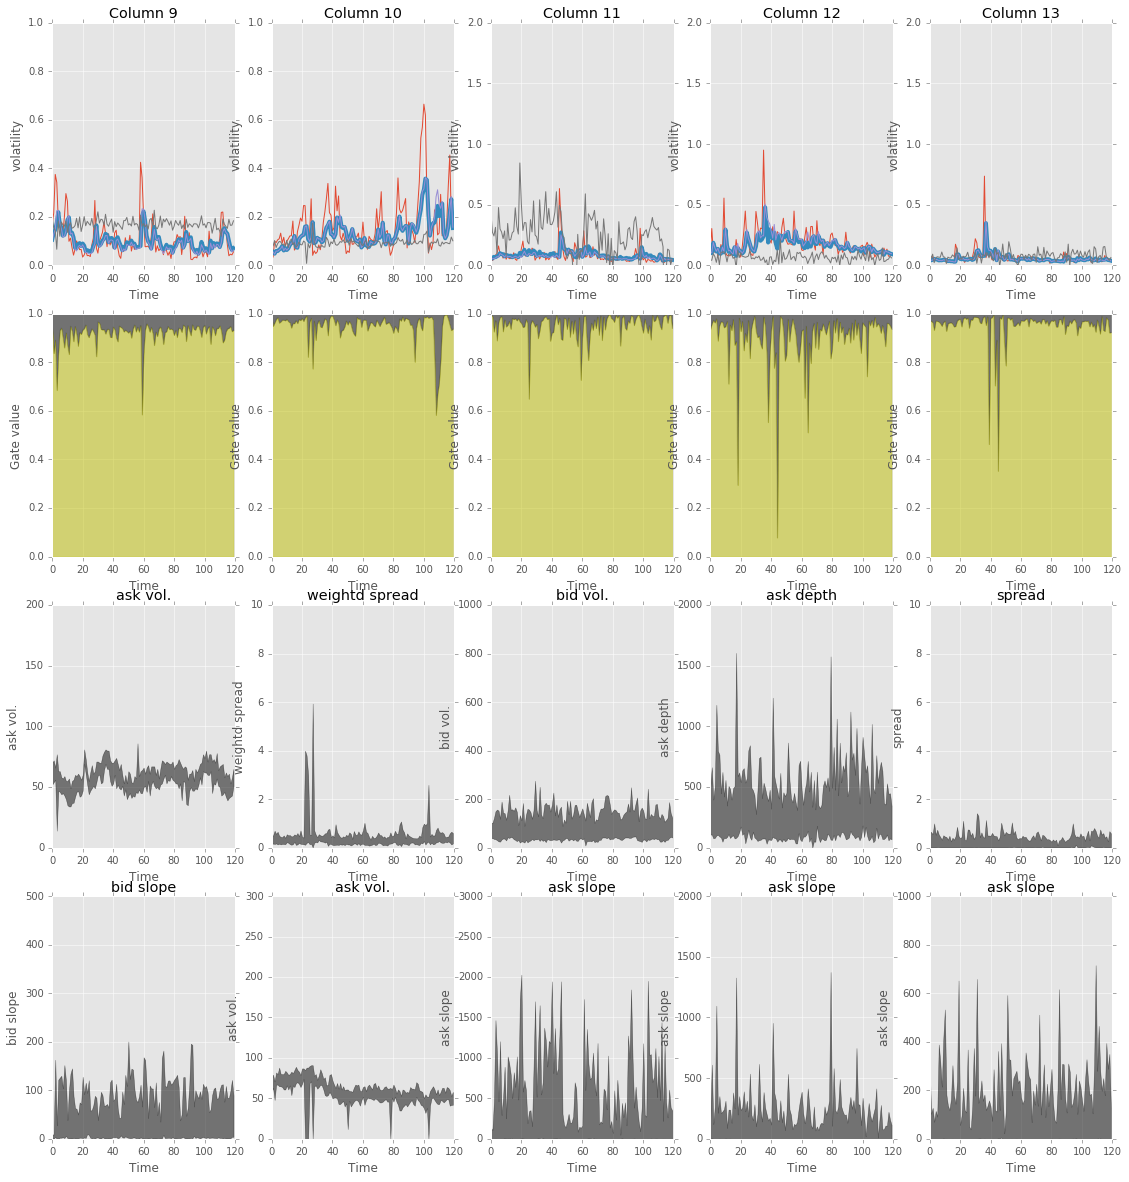

In [80]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [1, 1, 2, 2, 2]
feature_range = [ [ [0,200],[0,500] ], [ [0,10], [0,300] ], [ [0,1000], [0,3000] ], \
                  [ [0,2000],[0,2000] ], [ [0,10],[0,1000] ] ]

sample_group( [ 6, 5, 3, 2, 2 ], [ [300,420], [600,720], [200,320], [100,220], [320,440]  ],\
              [ [2, 8], [1, 2], [3, 9], [5, 9], [0, 9] ], feature_range, y_range, range(9, 14) )

(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


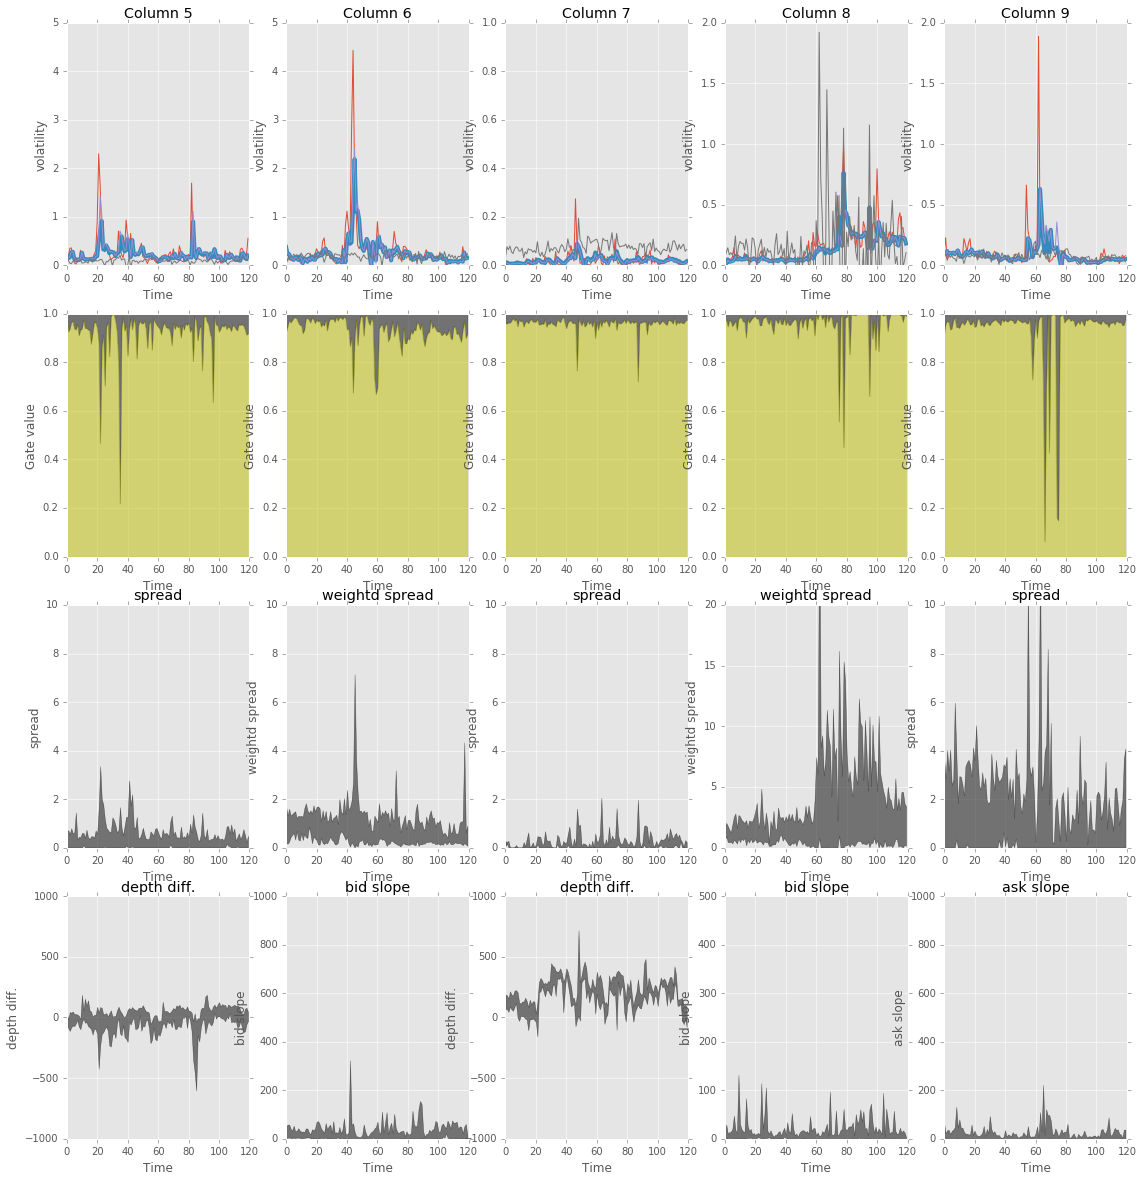

In [75]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [5, 5, 1, 2, 2]
feature_range = [ [ [0,10], [-1000, 1000] ], [ [0,10], [0,1000] ], [ [0,10],[-1000,1000] ], \
                [ [0, 20], [0, 500] ], [ [0,10],[0, 1000] ] ]

sample_group( [ 9, 10, 13, 15, 18 ], [ [600, 720], [500, 620], [0, 120], [600, 720], [0, 120] ],\
              [ [0, 7], [1, 8], [0, 7], [1, 8], [0,9] ], feature_range, y_range, range(5, 10) ) 

(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
------ test (120,)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)
(120, 16) (120, 30, 10)


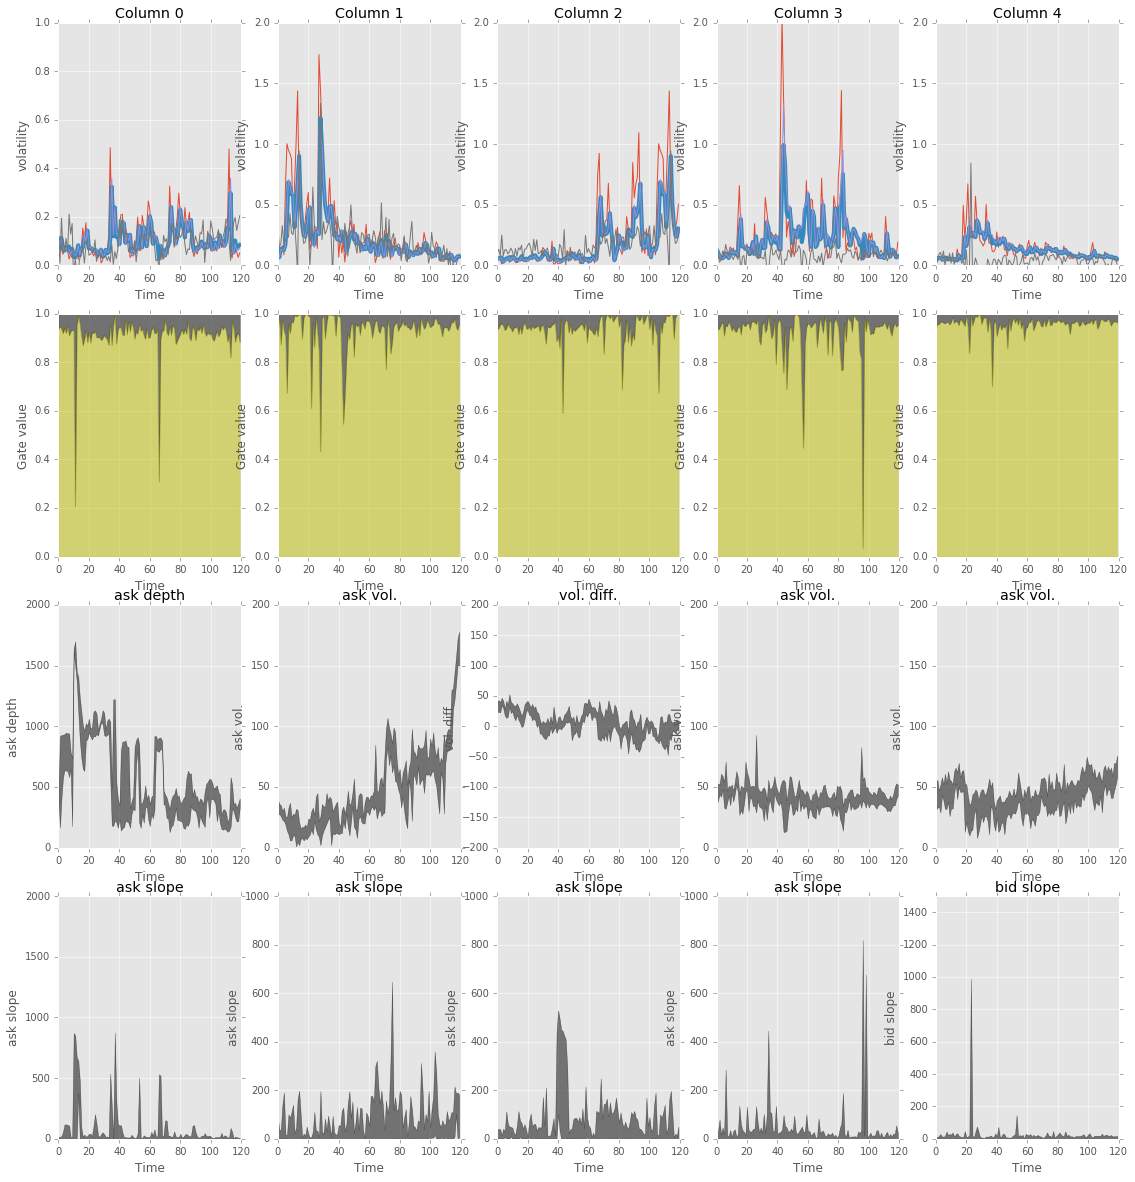

In [74]:
# Sample group

# 18, [0, 120], 0
#  17, [400, 520], 0
#  16, [80, 200], 0
#  15, [600, 720], 0
#  13, [600, 720], 0
#  13, [0, 120], 1
# 12, [0, 120], 0
# 11, [500, 620], 0
#  10, [500, 620], 0
# 9, [100, 220], 0
# 9, [600, 720], 1
# 8, [400, 520], 0
# 8, [300, 420], 1 

# 7, [250, 370], 0
# 6, [300, 420], 0
# 6, [450, 570], 1
# 5, [400, 520], 0
# 5, [150, 270], 1
# 5, [600, 720], 2
# 3, [200, 320], 0
# 2, [0, 120], 0 
# 2, [100, 220], 1 
# 2, [300, 420], 2

y_range = [1, 2, 2, 2, 2]
feature_range = [ [ [0,2000], [0, 2000] ], [ [0,200], [0,1000] ], [ [-200,200],[0,1000] ],\
                  [ [0,200], [0, 1000] ], [ [0,200], [0, 1500] ] ]

sample_group( [7, 8, 8, 9, 16], [ [250, 370], [400, 520], [300, 420], [100, 220], [80, 200] ],\
              [ [5, 9], [2, 9], [4, 9], [2, 9], [2, 8] ], feature_range, y_range, range(5) )

In [121]:
# Sample group

# sample plot
# TESTING

# feature_range = { 0:[0,10], 1:[0,10], 2:[0,350], 3:[0,350], 4:[-200, 200], \
#                 5:[0,3000], 6:[0,3000], 7:[-2000, 2000], 8:[0,1000], 9:[0,1000]}


def sample_group( intervals, segments, feature_ids, feature_range, y_range, cols ):    
    
    fig, ax = plt.subplots(4, len(intervals), figsize=(19,20))
    
#   Prediction and truth
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1]
        
        # DATA truth target values in testing 
        file_name = str(i) + '_' + pre_ts + 'mix' + post_txt
        df_pre = pd.read_csv( file_path + file_name, sep=',', names = col_format_mix)
        df_pre = df_pre.iloc[segl:segr]
        df_pre = df_pre.reset_index(drop=True)
        
        # truth and prediction
        ax[0][k].plot(df_pre['truth'], label = 'Truth')
        ax[0][k].plot(df_pre['pre'],   label = 'Prediction', linewidth = 4)
#         ax[0][k].plot(df_pre['pre_v'], label = 'pre_v')
#         ax[0][k].plot(df_pre['pre_b'],   label = 'pre_b')
        ax[0][k].set_ylim([0.0, y_range[k]])
        
#         ax[0][k].set_title('Column ' + str(cols[k]))
#         ax[0][k].set(xlabel='Time', ylabel='volatility')
        ax[0][k].legend(loc=0)
        
        ax[0][k].set_xlabel('Time', fontweight = 'bold')
        ax[0][k].set_ylabel('Volatility', fontweight = 'bold')
        
        
#   Gate value over time  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1]    
    
        # DATA gates in testing
        file_name = str(i) + '_' + gate_ts + post_txt
        df_gate = pd.read_csv( file_path + file_name, sep=',', names = col_format_gate )
        tmp_gate = np.asarray(df_gate)
        tmp_gate = tmp_gate[segl:segr] 
        
        # gate distribution
        X = range(len(tmp_gate))
        Y = [1.0 for j in tmp_gate ]
        Y1 = [j[0] for j in tmp_gate]
        Y2 = [0.0 for j in tmp_gate]
    
        ax[1][k].plot(Y, label = 'Order book', color='k', alpha=.5)
        ax[1][k].plot(Y1,label = 'Volatility', color = 'k', alpha=.1)
        ax[1][k].plot(Y2,)
        ax[1][k].fill_between(X, Y, Y1, color='k',alpha=.5)
        ax[1][k].fill_between(X, Y1,Y2, color='y',alpha=.5)
        
        ax[1][k].set_xlabel('Time', fontweight = 'bold')
        ax[1][k].set_ylabel('Gate value', fontweight = 'bold')
        
        ax[1][k].legend(loc=0)
    
#   Feature value  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1] 
        
        # DATA feature data
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
        x = np.load(data_path)[segl:segr]
    
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
        y = np.load(data_path)[segl:segr]
    
        # auto-regressive volatility, features 
        vol = np.asarray( [j[0] for j in x] )
        ob  = np.asarray( [j[1] for j in x] )
        print np.shape(vol), np.shape(ob)
        
        ob = np.transpose(ob, [2, 1, 0])
        max_ob = np.max(ob[feature_ids[k][0]], 0)
        min_ob = np.min(ob[feature_ids[k][0]], 0)
        
        print '------ test', np.shape(X) 
        
        
        ax[2][k].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
        
        ax[2][k].set_ylim( feature_range[k][0] )
        
#         ax[2][k].set_title(features_ob[feature_ids[k][0]])
#         ax[2][k].set( xlabel='Time', ylabel = features_ob[feature_ids[k][0]] )
        
        ax[2][k].set_xlabel('Time', fontweight = 'bold')
        ax[2][k].set_ylabel(features_ob[feature_ids[k][0]], fontweight = 'bold')
    
    
    
    cols = ['(a)', '(b)', '(c)']
#   Feature value  
    for k in range(len(intervals)):
        
        i = intervals[k]
        segl = segments[k][0]
        segr = segments[k][1] 
        
        # DATA feature data
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_xtest_mix" + post_dat
        x = np.load(data_path)[segl:segr]
    
        data_path = "../dataset/bitcoin/training_data/rolling/" + str(i) + "_ytest_mix" + post_dat
        y = np.load(data_path)[segl:segr]
    
        # auto-regressive volatility, features 
        vol = np.asarray( [j[0] for j in x] )
        ob  = np.asarray( [j[1] for j in x] )
        print np.shape(vol), np.shape(ob)
        
        ob = np.transpose(ob, [2, 1, 0])
        max_ob = np.max(ob[feature_ids[k][1]], 0)
        min_ob = np.min(ob[feature_ids[k][1]], 0)
        ax[3][k].fill_between(X, max_ob, min_ob, color='k',alpha=.5)
        
        ax[3][k].set_ylim(feature_range[k][1])
        
#         ax[3][k].set_title(features_ob[feature_ids[k][1]])
#         ax[3][k].set( xlabel='Time', ylabel = features_ob[feature_ids[k][1]] )
        
        ax[3][k].set_xlabel('Time \n' + cols[k] , fontweight = 'bold')
        ax[3][k].set_ylabel(features_ob[feature_ids[k][1]], fontweight = 'bold')
    
    fig.savefig('../bt_results/res/pics/sample/final_sample.jpeg', bbox_inches='tight')

(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
------ test (100,)
(100, 16) (100, 30, 10)
(100, 16) (100, 30, 10)
(100, 16) (100, 30, 10)


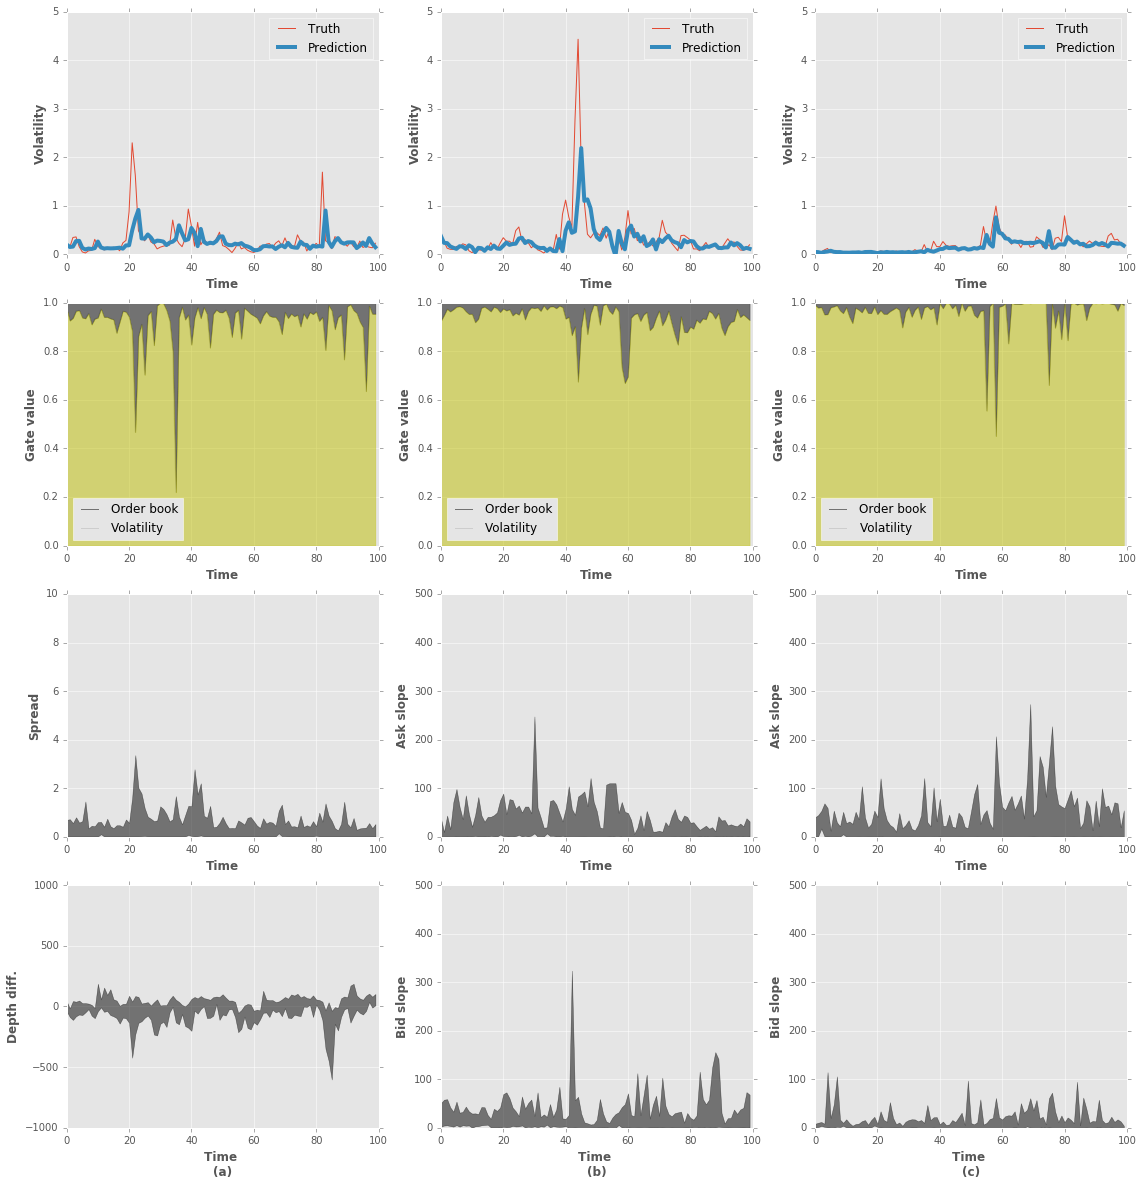

In [129]:
# final sample

y_range = [5, 5, 5]
feature_range = [ [ [0,10], [-1000, 1000] ], [ [0,500], [0,500] ], \
                  [ [0, 500], [0, 500] ] ]

sample_group( [ 9, 10, 15 ], [ [600, 700], [500, 600], [620, 720] ],\
              [ [0, 7], [9, 8], [9, 8] ], feature_range, y_range, range(5, 10) )

